In [2]:
conda install -c conda-forge findspark

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\spark-3.0.1-bin-hadoop2.7'

root
 |-- PlayerKey: integer (nullable = true)
 |-- GameID: string (nullable = true)
 |-- PlayKey: string (nullable = true)
 |-- BodyPart: string (nullable = true)
 |-- Surface: string (nullable = true)
 |-- DM_M1: integer (nullable = true)
 |-- DM_M7: integer (nullable = true)
 |-- DM_M28: integer (nullable = true)
 |-- DM_M42: integer (nullable = true)

root
 |-- PlayerKey: integer (nullable = true)
 |-- GameID: string (nullable = true)
 |-- PlayKey: string (nullable = true)
 |-- RosterPosition: string (nullable = true)
 |-- PlayerDay: integer (nullable = true)
 |-- PlayerGame: integer (nullable = true)
 |-- StadiumType: string (nullable = true)
 |-- FieldType: string (nullable = true)
 |-- Temperature: integer (nullable = true)
 |-- Weather: string (nullable = true)
 |-- PlayType: string (nullable = true)
 |-- PlayerGamePlay: integer (nullable = true)
 |-- Position: string (nullable = true)
 |-- PositionGroup: string (nullable = true)



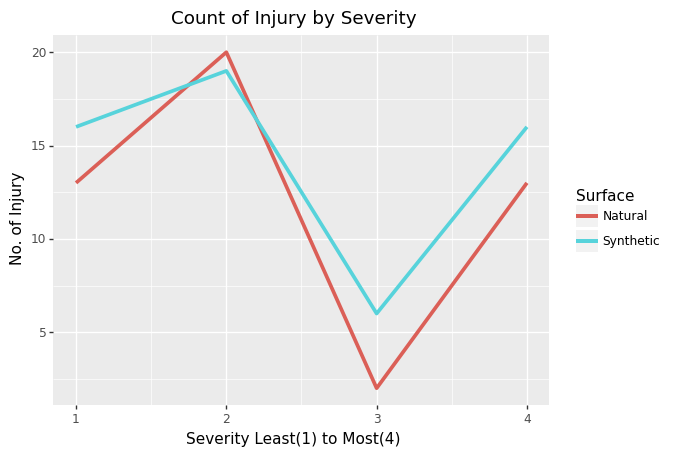

<ggplot: (117748754158)>


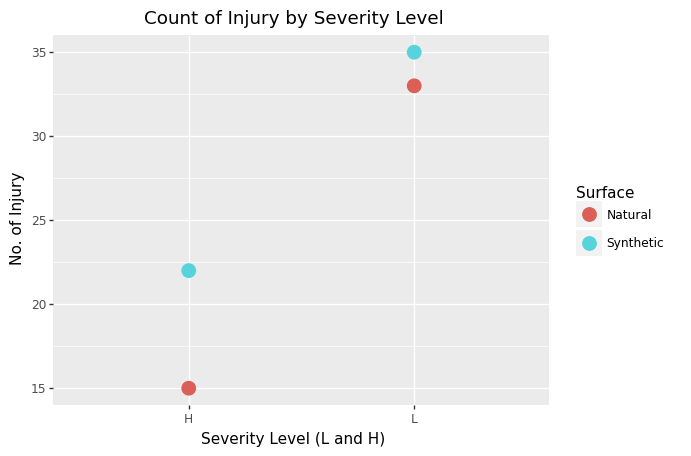

<ggplot: (117748754053)>


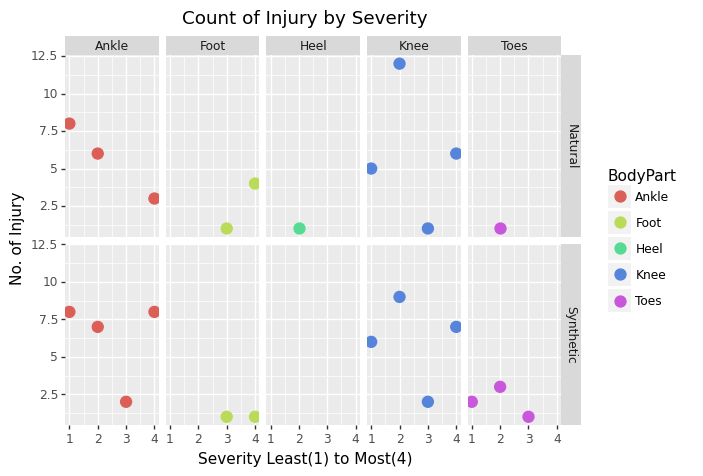

<ggplot: (117751040226)>


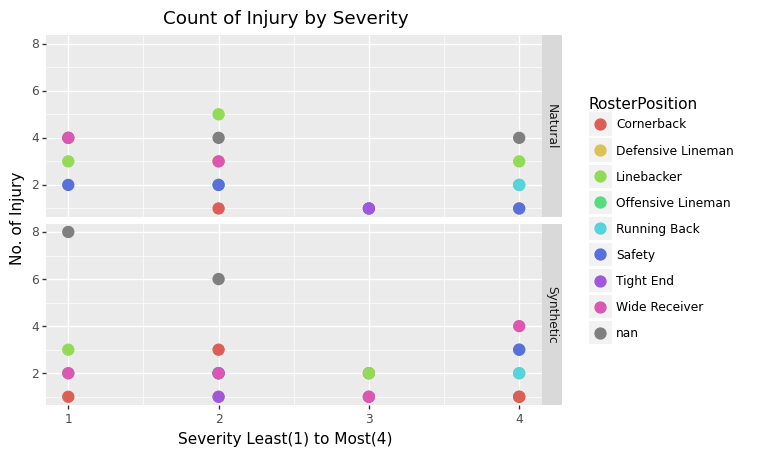

<ggplot: (117751567942)>


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from plotnine import *
#pip install plotly==3.10.0
#pip install plotly==4.1.0
#import plotly.plotly as py
#import plotly.graph_objs as go

#pip install chart_studio
#import chart_studio.plotly as py
#import plotly.graph_objects as go

import matplotlib.pyplot as plt
import pandas

if __name__ == "__main__":

    spark = SparkSession.builder.appName('cs5488project').getOrCreate()
    injury = spark.read.option("delimiter", ",").csv("PlayerTrackData.csv/InjuryRecord.csv",header=True,inferSchema=True)
    playlist = spark.read.option("delimiter", ",").csv("PlayerTrackData.csv/PlayList.csv",header=True,inferSchema=True)
    #playtrack = spark.read.option("delimiter", ",").csv("PlayerTrackData.csv/PlayerTrackData.csv",header=True,inferSchema=True)

    injury.printSchema()
    playlist.printSchema()
    #playtrack.printSchema()

    injury = injury.withColumn("Severity", col("DM_M1") + col("DM_M7") + col("DM_M28") + col("DM_M42"))
    injury = injury.withColumn("SevLevel", when(col("Severity") >=3, "H").otherwise("L"))
    injury = injury.select("PlayerKey","GameID","PlayKey","BodyPart","Surface","Severity","SevLevel")
 
    # 1, injury count by surface, severity -- a slightly higher rate for severe injury (missed day > 28 (DM_28 / DM_42)) for synthetic surface
    severity = injury.groupBy('Severity', 'Surface').count().orderBy(col("Severity").asc(), col('Surface').desc()).toPandas()
    sevLevel = injury.groupBy('SevLevel', 'Surface').count().orderBy(col("SevLevel").asc(), col('Surface').desc()).toPandas()
    
    p1 = ggplot(severity, aes(x='Severity', y='count')) + geom_line(aes(fill='Surface', color='Surface'), size=1.5) +\
        labs(x="Severity Least(1) to Most(4)", y='No. of Injury', title = 'Count of Injury by Severity')
    print(p1)
    
    p2 = ggplot(sevLevel, aes(x='SevLevel', y='count')) + geom_point(aes(color='Surface'), size=5) +\
        labs(x="Severity Level (L and H)", y='No. of Injury', title = 'Count of Injury by Severity Level')
    print(p2)    
    
    # 2, injury count by body part, severity, surface 
    # -- analyse by body part: ankle shows more severe injury on synthetic surface, knee and toes injury do not show significant difference on both surfaces
    # -- surprisingly, foot has more severe injury reported on natural surface  
    sevBodyPart = injury.groupBy('BodyPart', 'Severity','Surface').count().orderBy(col('BodyPart').asc(), col('Severity').desc(),col('Surface').asc()).toPandas()
    p3 = ggplot(sevBodyPart, aes(x='Severity', y="count")) + \
        geom_point(aes(color='BodyPart'), size=4) + \
        facet_grid('Surface ~ BodyPart') + \
        labs(x="Severity Least(1) to Most(4)", y='No. of Injury', title = 'Count of Injury by Severity')
    
    print(p3)
            

    # 3, injury count by roster position, severity, surface 
    # -- the percentage of record without roster position is significant in this dataset, the data are too scattered
    # -- no observation can be made
    detail = injury.join(playlist, injury.PlayKey == playlist.PlayKey, 'left')
    sevRosterPos = detail.groupBy('Surface','Severity','RosterPosition').count().orderBy(col('Severity').desc(), col('RosterPosition').asc()).toPandas()
    
    p4 = ggplot(sevRosterPos, aes(x='Severity', y="count")) + \
        geom_point(aes(color='RosterPosition'), size=4) + \
        facet_grid('Surface ~ ') + \
        labs(x="Severity Least(1) to Most(4)", y='No. of Injury', title = 'Count of Injury by Severity')
    print (p4)
       
    spark.stop()

In [117]:
 playtrack.show()

+---------+----+--------------------+-----+-----+------+----+------+----+
|  PlayKey|time|               event|    x|    y|   dir| dis|     o|   s|
+---------+----+--------------------+-----+-----+------+----+------+----+
|26624-1-1| 0.0|huddle_start_offense|87.46|28.93|288.24|0.01|262.33|0.13|
|26624-1-1| 0.1|                null|87.45|28.92|283.91|0.01|261.69|0.12|
|26624-1-1| 0.2|                null|87.44|28.92| 280.4|0.01|261.17|0.12|
|26624-1-1| 0.3|                null|87.44|28.92|278.79|0.01|260.66| 0.1|
|26624-1-1| 0.4|                null|87.44|28.92|275.44|0.01|260.27|0.09|
|26624-1-1| 0.5|                null|87.45|28.92|270.06|0.01|260.08|0.07|
|26624-1-1| 0.6|                null|87.46|28.92|265.05|0.01|260.05|0.05|
|26624-1-1| 0.7|                null|87.46|28.92|255.75| 0.0|260.28|0.02|
|26624-1-1| 0.8|                null|87.46|28.92|244.56| 0.0|260.72|0.01|
|26624-1-1| 0.9|                null|87.46|28.92|220.57| 0.0|261.26|0.01|
|26624-1-1| 1.0|                null|8

In [6]:
playtrack.show(1200)

+---------+----+--------------------+-----+-----+------+----+------+----+
|  PlayKey|time|               event|    x|    y|   dir| dis|     o|   s|
+---------+----+--------------------+-----+-----+------+----+------+----+
|26624-1-1| 0.0|huddle_start_offense|87.46|28.93|288.24|0.01|262.33|0.13|
|26624-1-1| 0.1|                null|87.45|28.92|283.91|0.01|261.69|0.12|
|26624-1-1| 0.2|                null|87.44|28.92| 280.4|0.01|261.17|0.12|
|26624-1-1| 0.3|                null|87.44|28.92|278.79|0.01|260.66| 0.1|
|26624-1-1| 0.4|                null|87.44|28.92|275.44|0.01|260.27|0.09|
|26624-1-1| 0.5|                null|87.45|28.92|270.06|0.01|260.08|0.07|
|26624-1-1| 0.6|                null|87.46|28.92|265.05|0.01|260.05|0.05|
|26624-1-1| 0.7|                null|87.46|28.92|255.75| 0.0|260.28|0.02|
|26624-1-1| 0.8|                null|87.46|28.92|244.56| 0.0|260.72|0.01|
|26624-1-1| 0.9|                null|87.46|28.92|220.57| 0.0|261.26|0.01|
|26624-1-1| 1.0|                null|8

NameError: name 'playtrack' is not defined